In [1]:
#general imports
import numpy as np
import pandas as pd


import unicodedata
import string
import re

#sklearn imports
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#nltk imports
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer

np.set_printoptions(linewidth=100)

sw = stopwords.words('english')
pt = string.punctuation
stemmer = SnowballStemmer('english')

## load data and drop image columns

In [2]:
df = pd.read_csv('skincare.csv')
df = df.reset_index(drop=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['Unnamed: 0.1'], axis=1, inplace=True);
df.head()

,Category,UserName,Product,UserReviewTitle,Url,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore,Image
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,$$$$$$,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi...",http://images.totalbeauty.com/uploads/tx_userp...
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Good but pricey,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i...",http://images.totalbeauty.com/uploads/tx_userp...
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Like Silk,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...


In [3]:
df.drop(['Image'], axis=1, inplace=True);

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60690 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         60690 non-null  object 
 1   UserName         52032 non-null  object 
 2   Product          60690 non-null  object 
 3   UserReviewTitle  52032 non-null  object 
 4   Url              60690 non-null  object 
 5   Brand            60690 non-null  object 
 6   ReviewText       52031 non-null  object 
 7   Rank             52032 non-null  float64
 8   OverallScore     52032 non-null  float64
 9   Featured         52032 non-null  float64
 10  UserRating       52032 non-null  float64
 11  Date             52032 non-null  object 
 12  ReviewTextMore   7965 non-null   object 
dtypes: float64(4), object(9)
memory usage: 6.0+ MB


In [5]:
df.Category.nunique()

22

In [6]:
#reduce datafame for ease of use
skindf = df.drop(['UserReviewTitle', 'Url'], axis=1);
skindf.head()

,Category,UserName,Product,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi..."
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i..."
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN


## Original Dataframe EDA & Basic Metrics

In [7]:
#how many unique products & unique users
users_count = df['UserName'].nunique()
products_count = df['Product'].nunique();
category_count = df['Category'].nunique();
print(f'Total number of users: {users_count}.  Total number of products: {products_count}.  Total number of categories: {category_count}')

Total number of users: 24071.  Total number of products: 14854.  Total number of categories: 22


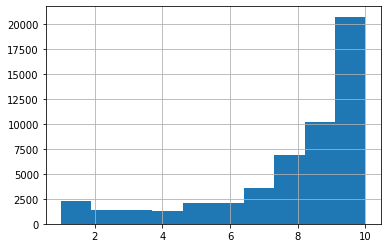

In [8]:
#histogram of user ratings
df['UserRating'].hist();

In [9]:
category = df.Category.value_counts()
category

More Moisturizer                       12034
More Cleanser                          10950
More Anti-Aging                         7014
More Eye Treatments                     4190
More Blemish + Acne Control             3923
More Masks, Peels                       3083
More Exfoliators, Scrubs                3055
More Makeup Remover                     2625
More Toners, Astringents                2219
More Night Cream                        2085
More Sun Protection                     1552
More Self Tanners                       1324
More Tools + Appliances                 1319
More Toothpaste + Breath Freshener      1262
More Lip Plumper                         956
More Oral Care                           649
More Dermatology Treatments & Peels      631
More Lightening Cream                    610
More Ingestibles + Supplements           513
More Microdermabrasion                   410
More Lip Exfoliant                       284
More                                       2
Name: Cate

## Make skincare dataframe for reduced scope

In [10]:
#make skincare dataframe for more specific recommender

In [11]:
skindf = df.query('Category == ["More Moisturizer","More Cleanser","More Anti-Aging","More Eye Treatments","More Blemish + Acne Control","More Masks, Peels, More Exfoliators, Scrubs","More Toners, Astringents","More Night Cream","More Sun Protection"]')
skindf.info()
#for now leave in unrated products

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43967 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         43967 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          43967 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Url              43967 non-null  object 
 5   Brand            43967 non-null  object 
 6   ReviewText       37760 non-null  object 
 7   Rank             37760 non-null  float64
 8   OverallScore     37760 non-null  float64
 9   Featured         37760 non-null  float64
 10  UserRating       37760 non-null  float64
 11  Date             37760 non-null  object 
 12  ReviewTextMore   5922 non-null   object 
dtypes: float64(4), object(9)
memory usage: 4.7+ MB


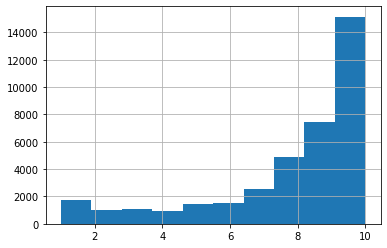

In [12]:
#histogram of user ratings
skindf['UserRating'].hist();

In [13]:
category_list = ["More Moisturizer","More Cleanser","More Anti-Aging","More Eye Treatments","More Blemish + Acne Control","More Masks, Peels, More Exfoliators, Scrubs","More Toners, Astringents","More Night Cream","More Sun Protection"]

In [14]:
skindf.Category.value_counts()

More Moisturizer               12034
More Cleanser                  10950
More Anti-Aging                 7014
More Eye Treatments             4190
More Blemish + Acne Control     3923
More Toners, Astringents        2219
More Night Cream                2085
More Sun Protection             1552
Name: Category, dtype: int64

In [15]:
#skindf.iloc[:4, 1]
#skindf.loc[:,'Category']

In [16]:
skindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43967 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         43967 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          43967 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Url              43967 non-null  object 
 5   Brand            43967 non-null  object 
 6   ReviewText       37760 non-null  object 
 7   Rank             37760 non-null  float64
 8   OverallScore     37760 non-null  float64
 9   Featured         37760 non-null  float64
 10  UserRating       37760 non-null  float64
 11  Date             37760 non-null  object 
 12  ReviewTextMore   5922 non-null   object 
dtypes: float64(4), object(9)
memory usage: 4.7+ MB


In [17]:
skindf = skindf[skindf['UserName'].notnull()]
skindf.drop(['Url'], axis=1, inplace=True);
skindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37760 entries, 0 to 51988
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         37760 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          37760 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Brand            37760 non-null  object 
 5   ReviewText       37760 non-null  object 
 6   Rank             37760 non-null  float64
 7   OverallScore     37760 non-null  float64
 8   Featured         37760 non-null  float64
 9   UserRating       37760 non-null  float64
 10  Date             37760 non-null  object 
 11  ReviewTextMore   5922 non-null   object 
dtypes: float64(4), object(8)
memory usage: 3.7+ MB


## Content Based Recommender

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jessicapmouras/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessicapmouras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jessicapmouras/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jessicapmouras/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
skindf['ReviewText'].head()

0    Crrrraaazzzyyyy expensive! But it works so gre...
1    WOW . . . .this is a really good product. I fi...
2    I started using the Elemis line about 6 months...
3    I had a complete facial, on a Carnival cruise ...
4    I purchased this a few years ago and WOW, just...
Name: ReviewText, dtype: object

### cleaning review text to capture good tagging words

In [20]:
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()


In [21]:
con_df = skindf;
con_df.head()

,Category,UserName,Product,UserReviewTitle,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,$$$$$$,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi..."
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Good but pricey,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i..."
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Like Silk,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN


In [22]:
def stop_word_remover(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2

In [23]:
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text) 
    text = text.replace("nbsp", "")
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if stop_word_remover(word)]
    clean_text2 = [word for word in clean_text if stop_word_remover(word)]
    return " ".join(clean_text2)

In [24]:
## combine review text and more revivew text for extra power for vocabulary

con_df['FullReviewText'] = con_df['ReviewText'].str.cat(con_df['ReviewTextMore'],sep=" ")
con_df.head()

,Category,UserName,Product,UserReviewTitle,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore,FullReviewText
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,$$$$$$,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN,NaN
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi...",WOW . . . .this is a really good product. I fi...
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Good but pricey,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i...",I started using the Elemis line about 6 months...
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN,NaN
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Like Silk,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN,NaN


In [25]:
# apply text cleaning
con_df['ReviewText'] = con_df['ReviewText'].apply(clean_txt)

In [26]:
con_df['ReviewText'].head()

0    crrrraaazzzyyyy expensive work great like use ...
1    wow really good product first learn website de...
2    start use elemis line months ago slowly start ...
3    complete facial carnival cruise months ago pur...
4    purchase years ago wow smooth totally dissolve...
Name: ReviewText, dtype: object

In [27]:
con_df.columns

Index(['Category', 'UserName', 'Product', 'UserReviewTitle', 'Brand',
       'ReviewText', 'Rank', 'OverallScore', 'Featured', 'UserRating', 'Date',
       'ReviewTextMore', 'FullReviewText'],
      dtype='object')

In [28]:
con_df.drop(['Category', 'UserName','UserReviewTitle','Rank', 'Featured','Brand', 'UserRating', 'Date', 'ReviewTextMore', 'FullReviewText', 'OverallScore'],axis=1, inplace=True);
con_df

,Product,ReviewText
0,Elemis Pro-Collagen Marine Cream,crrrraaazzzyyyy expensive work great like use ...
1,Elemis Pro-Collagen Marine Cream,wow really good product first learn website de...
2,Elemis Pro-Collagen Marine Cream,start use elemis line months ago slowly start ...
3,Elemis Pro-Collagen Marine Cream,complete facial carnival cruise months ago pur...
4,Elemis Pro-Collagen Marine Cream,purchase years ago wow smooth totally dissolve...
...,...,...
51773,Proactiv Renewing Cleanser,use everday like instructions say see result d...
51774,Proactiv Renewing Cleanser,part three step program work amazingly well ge...
51808,BeautyRx by Dr. Schultz Balancing Glycolic Cle...,glycolic acid cleanser felt really gentle flip...
51873,Dr. Jart+ Water Drop Hydrating Moisturizer,really interest product come tube gel balm tex...


In [29]:
con_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37760 entries, 0 to 51988
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Product     37760 non-null  object
 1   ReviewText  37760 non-null  object
dtypes: object(2)
memory usage: 885.0+ KB



### Update dataframe to be singular products with total review text as document

In [30]:
con_df['Product'].value_counts()

Olay Complete All Day Moisturizer with Sunscreen Broad Spectrum SPF 15 - Normal    1224
Olay Regenerist Regenerating Serum                                                  720
Nu Skin AgeLoc Future Serum                                                         539
Philosophy Purity Made Simple Foaming 3-in-1 Cleansing Gel for Face and Eyes        530
Olay 4-in-1 Daily Facial Cloths - Normal Skin                                       486
                                                                                   ... 
Love for Humanity Organics Anti-Aging Eye Serum                                       1
Lancaster Comforting Cleansing Milk                                                   1
Boscia Tsubaki Cleansing Oil-Gel                                                      1
DHC Neck Treatment Essence Peptides                                                   1
Votre Vu  SPÉCIALEYES Specialize Intensive Eye Treatment                              1
Name: Product, Length: 4621, dty

In [31]:
con_df['Helper'] = np.where(con_df['Product'] == '', 0, 1)

In [32]:
con_df.Helper.value_counts()

1    37760
Name: Helper, dtype: int64

In [33]:
con_df.drop(['Helper'],axis=1, inplace=True);
con_df.head()

,Product,ReviewText
0,Elemis Pro-Collagen Marine Cream,crrrraaazzzyyyy expensive work great like use ...
1,Elemis Pro-Collagen Marine Cream,wow really good product first learn website de...
2,Elemis Pro-Collagen Marine Cream,start use elemis line months ago slowly start ...
3,Elemis Pro-Collagen Marine Cream,complete facial carnival cruise months ago pur...
4,Elemis Pro-Collagen Marine Cream,purchase years ago wow smooth totally dissolve...


In [34]:
con_df.sample(frac=1)

,Product,ReviewText
46073,Burt's Bees Herbal Blemish Stick,think product great take little get use smell ...
19128,Laura Mercier Tinted Moisturizer Broad Spectru...,love tint moisturizer funny sephora look new f...
34099,Estée Lauder Advanced Night Repair Synchronize...,wish work unfortunately visible result use hal...
7090,Obagi Nu-Derm Clear,use couple years product work dark patch sun d...
42597,Clarins Truly Matte Blemish Control,love much wheni buy huge spot chin put product...
...,...,...
7962,Nu Skin AgeLoc Future Serum,excite product half face previous ageloc produ...
43846,Proactiv Deep Cleansing Wash,love product use every morning along proactiv ...
47194,Olay Regenerist Eye Derma-Pod Anti Aging Tripl...,second box use daily rather every days really ...
50183,University Medical Acne Free Clear Skin Treatm...,use proactive years early feed mandatory auto ...


In [35]:
newtestseries = con_df.groupby(["Product"])['ReviewText'].apply(list)

In [36]:
print(type(newtestseries))

<class 'pandas.core.series.Series'>


In [37]:
newtestdf = newtestseries.to_frame();
newtestdf.reset_index()

,Product,ReviewText
0,1 Day Acuvue Brand Contact Lenses,[try different brand husband remain loyal john...
1,1 Day Acuvue Moist Brand Contact Lenses,[really love acuvue contact help see better ea...
2,100% Pure Aqua Boost Hydrating Mask,[kind face mask cream freak test lot different...
3,100% Pure Argan Oil Hydration Facial Moisturiz...,[pure argan oil hydration facial moisturizer s...
4,100% Pure Korres White Tea Facial Fluid Gel Cl...,[love cleanser normal dry skin use product ski...
...,...,...
4616,mark Let's Be Clear Blemish Neutralizing Clean...,[use product couple time okay really need dry ...
4617,no!no! FaceTrainer,[ive try days get use weird look kid couldnt s...
4618,pur-lisse pur~protect spf 30,[receive sample decide use today pleasantly su...
4619,pur~lisse pur~delicate gentle soy milk cleanse...,[face cleanser delicate skin thoroughly clean ...


In [38]:
newtestmatrix = newtestdf.ReviewText.values;
newtestmatrix[588]


['life normal soft clear skin try many cream serums nothing ever really work would break get rash face would get really oily dry try serum find make face really soft face isnt dry oily break get rashes perfect smell also bonus get nice baby powdery sort smell',
 'get serum sample love little long way use every day face seem younger healthier bite glow side pretty expensive']

In [39]:
test_df = newtestdf.iloc[:20000,:].reset_index();

test_df.head()

,Product,ReviewText
0,1 Day Acuvue Brand Contact Lenses,[try different brand husband remain loyal john...
1,1 Day Acuvue Moist Brand Contact Lenses,[really love acuvue contact help see better ea...
2,100% Pure Aqua Boost Hydrating Mask,[kind face mask cream freak test lot different...
3,100% Pure Argan Oil Hydration Facial Moisturiz...,[pure argan oil hydration facial moisturizer s...
4,100% Pure Korres White Tea Facial Fluid Gel Cl...,[love cleanser normal dry skin use product ski...


In [40]:
test_df['ReviewText2'] = [','.join(map(str, l)) for l in test_df['ReviewText']];
test_df.head()

,Product,ReviewText,ReviewText2
0,1 Day Acuvue Brand Contact Lenses,[try different brand husband remain loyal john...,try different brand husband remain loyal johns...
1,1 Day Acuvue Moist Brand Contact Lenses,[really love acuvue contact help see better ea...,really love acuvue contact help see better eas...
2,100% Pure Aqua Boost Hydrating Mask,[kind face mask cream freak test lot different...,kind face mask cream freak test lot different ...
3,100% Pure Argan Oil Hydration Facial Moisturiz...,[pure argan oil hydration facial moisturizer s...,pure argan oil hydration facial moisturizer sp...
4,100% Pure Korres White Tea Facial Fluid Gel Cl...,[love cleanser normal dry skin use product ski...,love cleanser normal dry skin use product skin...


In [41]:
content_df = test_df.drop(['ReviewText'],axis=1)
content_df.set_index(['Product'], inplace=True);
content_df.head()

,ReviewText2
Product,
1 Day Acuvue Brand Contact Lenses,try different brand husband remain loyal johns...
1 Day Acuvue Moist Brand Contact Lenses,really love acuvue contact help see better eas...
100% Pure Aqua Boost Hydrating Mask,kind face mask cream freak test lot different ...
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,pure argan oil hydration facial moisturizer sp...
100% Pure Korres White Tea Facial Fluid Gel Cleanser,love cleanser normal dry skin use product skin...


## Content based item recommender based on input of preferred item

In [42]:

import pandas as pd
from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import re

class ItemRecommender():
    '''
    Content based item recommender
    '''
    def __init__(self, similarity_measure=None):
        self.similarity_matrix = None
        self.item_names = None

        if similarity_measure == None:
            self.similarity_measure = cosine_similarity
        else:
            self.similarity_measure = similarity_measure

    
    def fit(self, X, titles=None):
        '''
        Takes a numpy array of the item attributes and creates the similarity matrix
        INPUT -
            X: NUMPY ARRAY - Rows are items, columns are feature values / or DF
            titles: LIST - List of the item names/titles in order of the numpy arrray
        
        OUTPUT - None
        Notes:  You might want to keep titles and X as attributes to refer to them later
        Create the a similarity matrix of item to item similarity
        '''

        # While keeping this as a sparse matrix would be best the cosign sim
        # function returns a array so there is no reason.
        
        if isinstance(X, pd.DataFrame):
            self.item_counts = X
            self.item_names = X.index
            self.similarity_df = pd.DataFrame(self.similarity_measure(X.values, X.values),
                 index = self.item_names)
        else:
            self.item_counts = X
            self.similarity_df = pd.DataFrame(self.similarity_measure(X, X),
                 index = titles)
            self.item_names = self.similarity_df.index

        
    def get_recommendations(self, item, n=5):
        '''
        Returns the top n items related to the item passed in
        INPUT:
            item    - STRING - Name of item in the original DataFrame 
            n       - INT    - Number of top related items to return 
        OUTPUT:
            items - List of the top n related item names
        For a given item find the n most similar items to it (this can be done using the similarity matrix created in the fit method)
        '''
        return self.item_names[self.similarity_df.loc[item].values.argsort()[-(n+1):-1]].values[::-1]


    def get_user_profile(self, items):
        '''
        Takes a list of items and returns a user profile. A vector representing the likes of the user.
        INPUT: 
            items  -   LIST - list of movie names user likes / has seen
        OUTPUT: 
            user_profile - NP ARRAY - array representing the likes of the user 
                    The columns of this will match the columns of the trained on matrix
    
        Using the list of items liked by the user create a profile which will be a 1 x number of features array.  This should be the addition of the values for all liked item features (you can choose how to normalize if you think it is needed)
        '''
        user_profile = np.zeros(self.item_counts.shape[1])
        for item in items:
            user_profile += self.item_counts.loc[item].values

        return user_profile


    def get_user_recommendation(self, items, n=5):
        '''
        Takes a list of movies user liked and returns the top n items for that user
        INPUT 
            items  -   LIST - list of movie names user likes / has seen
            n -  INT - number of items to return
        OUTPUT 
            items - LIST - n recommended items
    
        Make use of the get_user_profile method to create a user profile that will be used to get the similarity to all items and recommend the top n.
        '''
        num_items = len(items)
        user_profile = self.get_user_profile(items)

        user_sim =  self.similarity_measure(self.item_counts, user_profile.reshape(1,-1))

        return self.item_names[user_sim[:,0].argsort()[-(num_items+n):-num_items]].values[::-1]


### CountVectorizer

In [43]:
 # instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(content_df['ReviewText2'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(content_df.index)

In [44]:

rec = ItemRecommender()
count_df = pd.DataFrame(count_matrix.todense(), index=indices.values)


In [45]:
rec.fit(count_df)



In [46]:

print(rec.get_recommendations('100% Pure Korres White Tea Facial Fluid Gel Cleanser'))

['Dermalogica Special Cleansing Gel' 'Avalon Organics Vitamin C Refreshing Cleansing Gel'
 'bareMinerals Purifying Facial Cleanser' 'Aveeno Clear Complexion Foaming Cleanser'
 'Aveeno Positively Radiant Cleanser']


### TF-IDF

In [47]:
# instantiating and generating the count matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0)
tfidf_matrix = count.fit_transform(content_df['ReviewText2'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(content_df.index)

In [48]:
rec = ItemRecommender()
count_df = pd.DataFrame(count_matrix.todense(), index=indices.values)


In [49]:
rec.fit(count_df)

In [50]:
print(rec.get_recommendations('100% Pure Korres White Tea Facial Fluid Gel Cleanser'))

['Dermalogica Special Cleansing Gel' 'Avalon Organics Vitamin C Refreshing Cleansing Gel'
 'bareMinerals Purifying Facial Cleanser' 'Aveeno Clear Complexion Foaming Cleanser'
 'Aveeno Positively Radiant Cleanser']
